In [1]:
import pandas
import datetime
def dateparse (time_in_secs):    
    return datetime.datetime.fromtimestamp(float(time_in_secs))

x = pandas.read_csv('../datapoints.txt',delimiter='\t', parse_dates=True, date_parser=dateparse, index_col='DateTime', names=['DateTime', 'EN', 'INTL', "NOLANG"], header=None)


In [2]:
x.head()

,EN,INTL,NOLANG
DateTime,,,
2021-11-17 08:28:35.465753,2831,70994,35051
2021-11-17 08:28:42.045611,2416,72300,36110
2021-11-17 08:29:05.925849,3168,76426,39988
2021-11-17 08:29:18.235397,2111,80122,39699
2021-11-17 08:29:31.725540,2703,79553,42038


In [3]:
# Import necessary packages
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Use white grid plot background from seaborn
sns.set(font_scale=1.5, style="whitegrid")

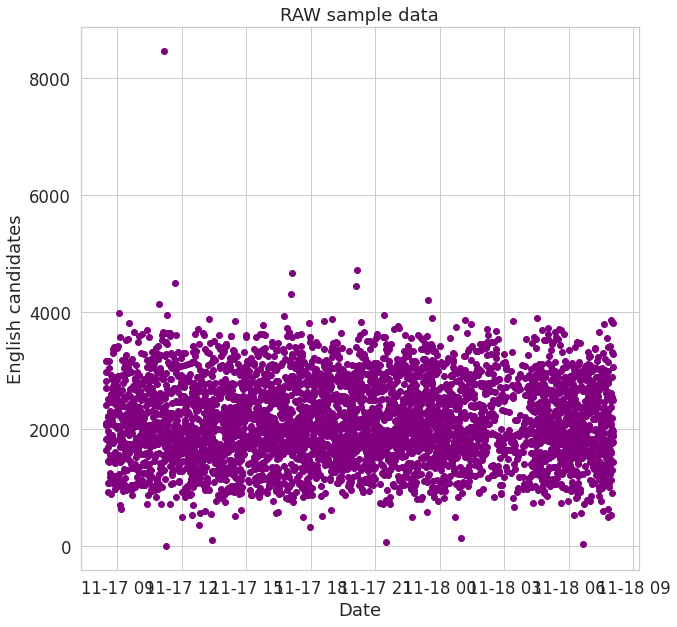

In [4]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.scatter(x.index.values,
           x['EN'],
           color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="English candidates",
       title="RAW sample data")

plt.show()

In [5]:
re = x.resample('H').sum()

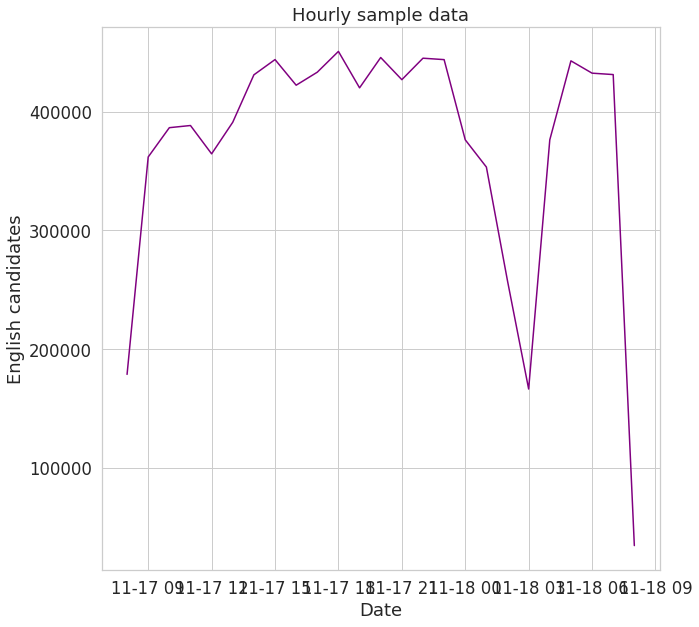

In [6]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.plot(re.index.values,
           re['EN'],
           color='purple')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="English candidates",
       title="Hourly sample data")

plt.show()

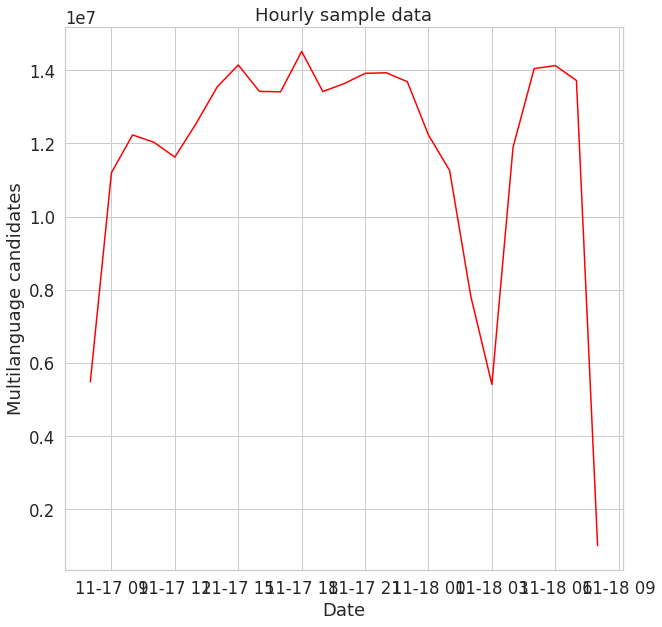

In [7]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.plot(re.index.values,
           re['INTL'],
           color='red')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Multilanguage candidates",
       title="Hourly sample data")

plt.show()

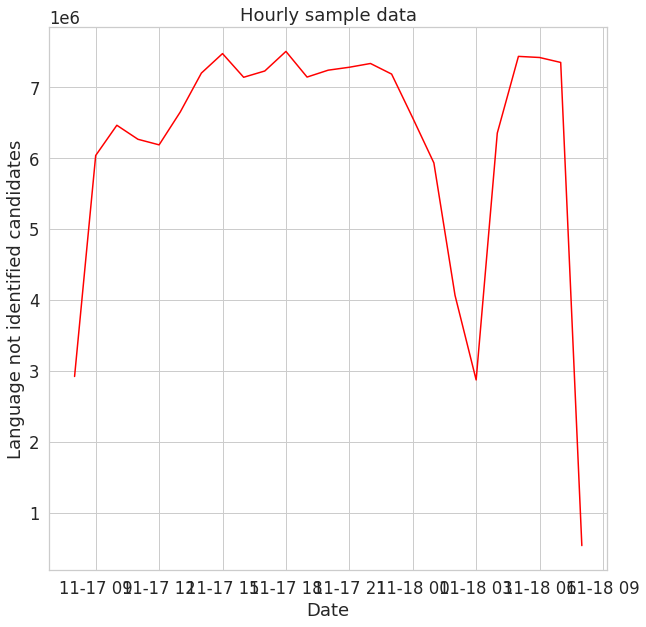

In [8]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(10, 10))

# Add x-axis and y-axis
ax.plot(re.index.values,
           re['NOLANG'],
           color='red')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Language not identified candidates",
       title="Hourly sample data")

plt.show()